# Starting with a Simple Example: Digits Data from sklearn
Let's start our adventure into convolutional networks with a simple example of the digits dataset. This was not always such a simple example, but modern day computing power and open source tools has made it a significantly more tractable problem. 

Note that we will not be using the `tf.data` format for these example since they are sufficiently small enought to work with. 

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

print('Tensorflow version:',tf.__version__)

tf.random.set_seed(2)
np.random.seed(0) # using this to help make results more reproducible
tf.config.list_physical_devices('GPU')

digits = datasets.load_digits()

# NORMALIZATION, SO IMPORTANT
X = digits.data.astype(np.float32)/16.0 - 0.5
y = digits.target.astype(np.int32)

X = X.reshape((X.shape[0],8,8,1)) # reshape as images

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Split X_train again to create validation data
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

X_train.shape

Tensorflow version: 2.13.0


(1437, 8, 8, 1)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

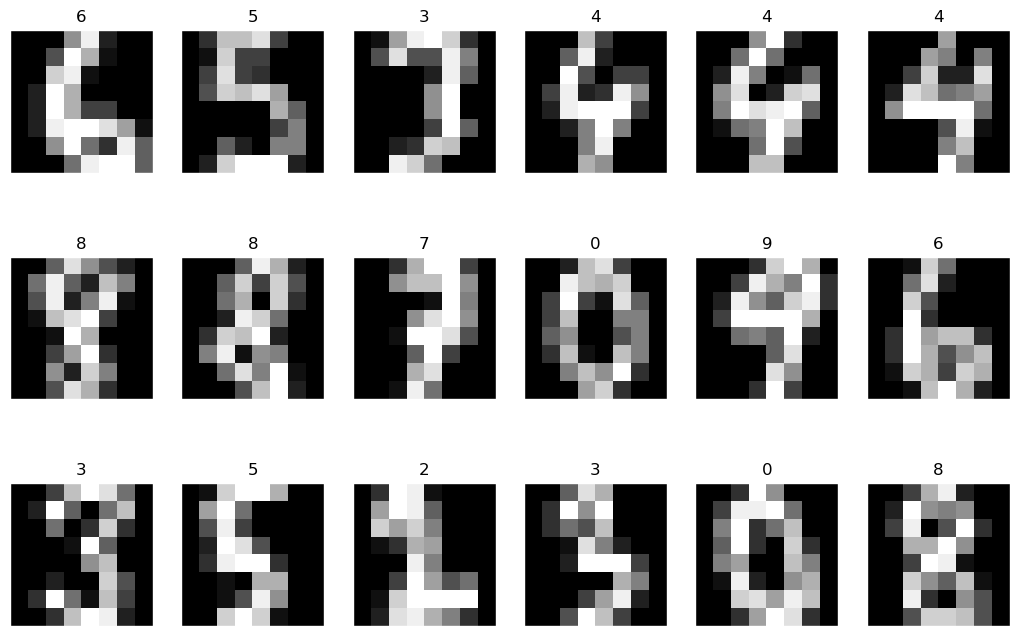

In [3]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 8, 8) # defaults to showing a 3 by 6 subset of the images



____
# A very Simple ConvNet Versus a Raw Pixel Input MLP
Wouldn't it be great if we did not need to specify the correct filters (like in DAISY)? What if we could just let the weights of the convolution be found through neural network training methods. Of course, we can! Let's do one example with a simple CNN architecture and compare it to the performance of a pixel wise MLP.

In general, the flattened images placed through a MLP can be quite accurate (as we have seen in the past). Even so, using convolitional filters and pooling should provide us with some better resilience to small perturbations in the images. 

**BONUS**: Let's start using the sequential API, rather than the funcitonal API. Also, we can use numpy matrices instead of the tf.data format for smaller examples. The format will mean that the models are not quite as fast for loading data, but since everythign fits in memory its not a huge concern. 

Note that, since we are not using tf.data, we need to normalize the input data directly, rather than as part of th model. 

In [5]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

# keras.__version__

In [6]:
NUM_CLASSES = 10
print(X_train.shape)
print(X_test.shape)

(1437, 8, 8, 1)
(360, 8, 8, 1)


In [7]:
%%time

# CREATE A BASELINE MLP WITH THREE LAYERS

# since this is not binary, we should go ahead and one-hot encode the inputs
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

2023-11-24 18:58:31.832679: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-24 18:58:31.832734: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-24 18:58:31.832747: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-24 18:58:31.833255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-24 18:58:31.833519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-24 18:58:32.784865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 46.6 s, sys: 12.3 s, total: 58.9 s
Wall time: 51.3 s


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 16)          80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 16)          0         
 D)                                                              
                                                                 
 activation_1 (Activation)   (None, 4, 4, 16)          0         
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                      

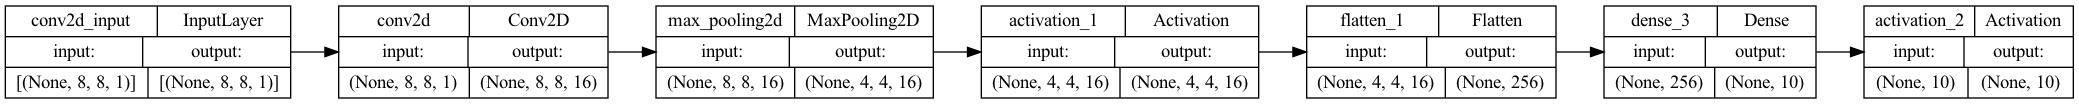

In [8]:
%%time

# CREATE A CNN WITH ONLY ONE CONVOLUTIONAL LAYER AND ONE OUTPUT LAYER

# make a CNN with conv layer and max pooling
cnn = Sequential() 
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same', 
                input_shape=(8,8,1),
               ) )

cnn.add( MaxPooling2D(pool_size=(2, 2)) )
cnn.add( Activation('relu') )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

print(cnn.summary())

plot_model(
    cnn, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [9]:
%%time 

# the shape of input (batch x h x w x channels)
print(X_train.shape)

# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

(1437, 8, 8, 1)


2023-11-24 19:02:48.668110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 41.6 s, sys: 12.9 s, total: 54.5 s
Wall time: 47.2 s


In [10]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(f'CNN: {acc_cnn:.4f}')
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title(f'MLP: {acc_mlp:.4f}')

 1/12 [=>............................] - ETA: 1s

2023-11-24 19:03:35.861873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/12 [========================>.....] - ETA: 0s

2023-11-24 19:03:36.551057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 31ms/step


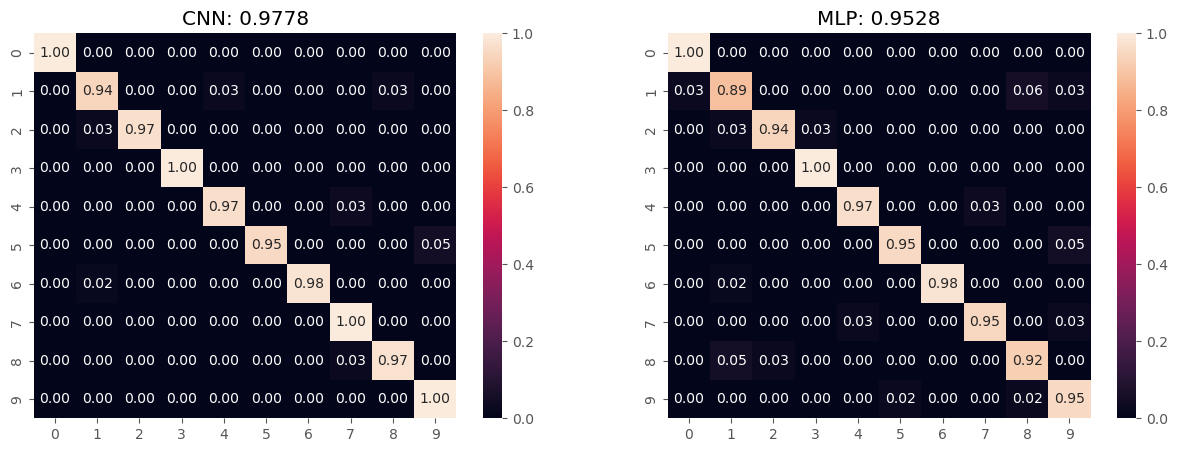

In [11]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

Model: "3by3_kernel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          160       
                                                                 
 activation_3 (Activation)   (None, 8, 8, 16)          0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 2730 (10.66 KB)
Trainable params: 2730 (10.66 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

2023-11-24 19:03:37.613620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/12 [=>............................] - ETA: 1s

2023-11-24 19:04:24.381909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 2ms/step
CPU times: user 42.9 s, sys: 13 s, total: 55.8 s
Wall time: 47.5 s


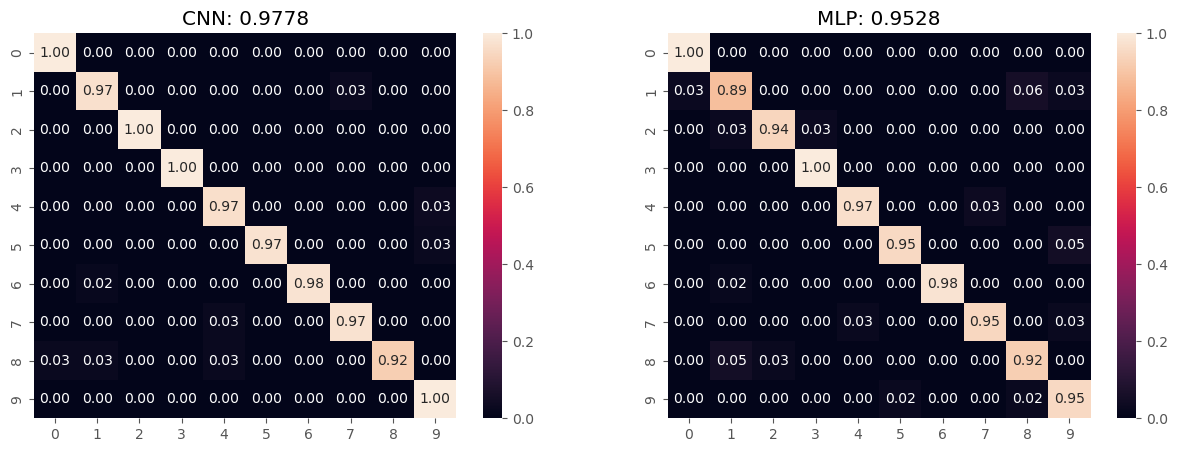

In [12]:
%%time

# changes: 
#    1. increased kernel size
cnn2 = Sequential(name='3by3_kernel')
cnn2.add( Conv2D(filters=16, kernel_size= (3, 3), 
                padding='same', input_shape=(8,8,1),
                ) )
cnn2.add( Activation('relu') )
cnn2.add( MaxPooling2D(pool_size=(2, 2)) )
# add one layer on flattened output
cnn2.add( Flatten() )
cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

input_shape = [None, 8,8,1]
cnn2.build(input_shape)
print(cnn2.summary())

cnn2.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn2,mlp,X_test,y_test)

Model: "two_layer_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          320       
                                                                 
 activation_4 (Activation)   (None, 8, 8, 32)          0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 32)          9248      
                                                                 
 activation_5 (Activation)   (None, 4, 4, 32)          0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 32)          0         
 g2D)                                                

2023-11-24 19:04:25.606403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/12 [=>............................] - ETA: 2s

2023-11-24 19:05:24.544743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 2ms/step
CPU times: user 52.6 s, sys: 13.9 s, total: 1min 6s
Wall time: 1min


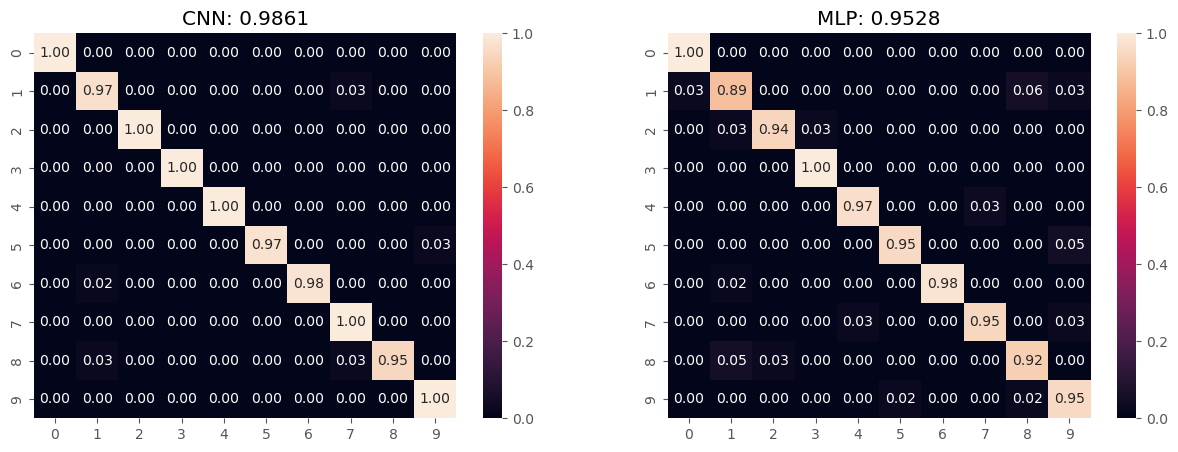

In [13]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer 
cnn3 = Sequential(name='two_layer_cnn')

num_filt_layers = [32, 32]
for num_filters in num_filt_layers:
    cnn3.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',
                     ) )
    cnn3.add( Activation('relu'))
    cnn3.add( MaxPooling2D(pool_size=(2, 2)) )
    

# add one layer on flattened output
cnn3.add( Flatten() )
cnn3.add( Dense(NUM_CLASSES) )
cnn3.add( Activation('softmax') )

# Let's train the model 
cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

input_shape = [None, 8,8,1]
cnn3.build(input_shape)
print(cnn3.summary())

cnn3.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn3,mlp,X_test,y_test)

Model: "two_layer_few_filters"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 8, 8, 16)          160       
                                                                 
 activation_7 (Activation)   (None, 8, 8, 16)          0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 32)          4640      
                                                                 
 activation_8 (Activation)   (None, 4, 4, 32)          0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 32)          0         
 g2D)                                        

2023-11-24 19:05:26.063728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/12 [=>............................] - ETA: 2s

2023-11-24 19:06:31.560716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 2ms/step
CPU times: user 1min, sys: 14.3 s, total: 1min 14s
Wall time: 1min 6s


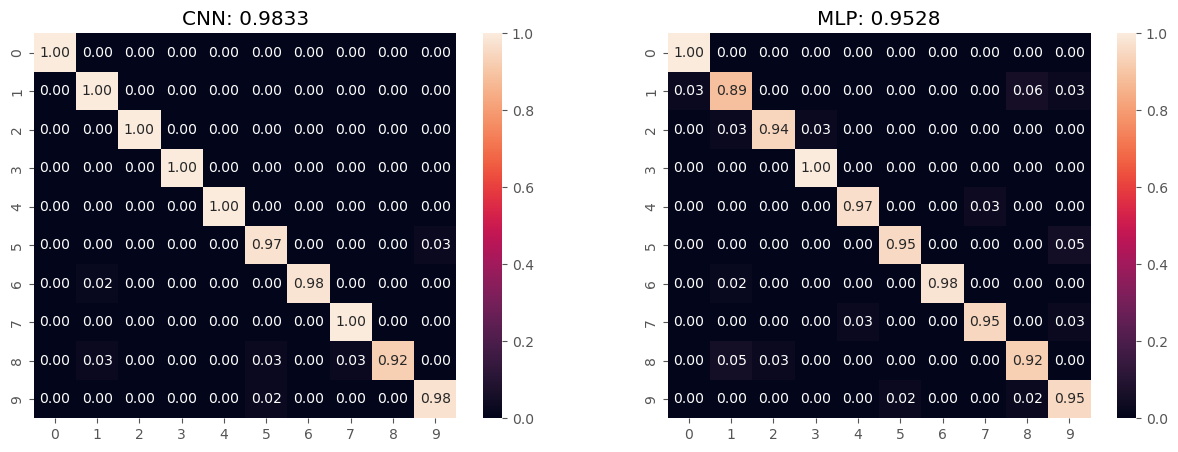

In [14]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters
#    3. add more layers once flattened
cnn4 = Sequential(name='two_layer_few_filters')

num_filt_layers = [16, 32]
for num_filters in num_filt_layers:
    cnn4.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn4.add( Activation('relu'))
    cnn4.add( MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn4.add( Flatten() )
cnn4.add( Dense(100) )
cnn4.add( Activation('relu') )
cnn4.add( Dense(NUM_CLASSES) )
cnn4.add( Activation('softmax') )

# Let's train the model 
cnn4.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

input_shape = [None, 8,8,1]
cnn4.build(input_shape)
print(cnn4.summary())

cnn4.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn4,mlp,X_test,y_test)

# Fashion MNIST
Okay, so we are honing in on the best performance for the digits data. But, we really need something a bit bigger to work on. Enter: Fashion MNIST. We have already used this dataset in the past, where we got about 84% accuracy with our custom MLP. Lets see how well Keras and tensorflow can perform!

Now let's load in a more diverse, harder to classify dataset: Fashion MNIST
https://www.kaggle.com/zalando-research/fashionmnist

**Labels**

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot 

In [15]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='fashion_train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='fashion_train')
X_test, y_test = load_mnist('data/', kind='fashion_t10k')

X_train = X_train.reshape(X_train.shape[0],28,28,1)/255.0 - 0.5
X_test = X_test.reshape(X_test.shape[0],28,28,1)/255.0 - 0.5

print('X_train shape:', X_train.shape) 
print('X_test shape:', X_test.shape)

NUM_CLASSES = 10


# make one- hot encoded versions of the data
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [16]:
%%time

# make a keras MLP
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=1, units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

input_shape = [None, 28,28,1]
mlp.build(input_shape)
print(mlp.summary())

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 10)                510       
                                                                 
 activation_11 (Activation)  (None, 10)                0         
                                                                 
Total params: 86610 (338.32 KB)
Trainable params: 8661

2023-11-24 19:06:33.592522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 87s 44ms/step - loss: 0.7440 - accuracy: 0.7595
Epoch 2/15
1875/1875 [==============================] - 84s 45ms/step - loss: 2.2094 - accuracy: 0.7204
Epoch 3/15
1875/1875 [==============================] - 83s 44ms/step - loss: 11.4042 - accuracy: 0.6534
Epoch 4/15
1875/1875 [==============================] - 86s 46ms/step - loss: 50.5973 - accuracy: 0.5903
Epoch 5/15
1875/1875 [==============================] - 86s 46ms/step - loss: 191.1505 - accuracy: 0.5261
Epoch 6/15
1875/1875 [==============================] - 85s 45ms/step - loss: 594.3969 - accuracy: 0.4676
Epoch 7/15
1875/1875 [==============================] - 87s 46ms/step - loss: 1491.5342 - accuracy: 0.4181
Epoch 8/15
1875/1875 [==============================] - 87s 46ms/step - loss: 3259.1157 - accuracy: 0.3808
Epoch 9/15
1875/1875 [==============================] - 83s 44ms/step - loss: 6241.6528 - accuracy: 0.3583
Epoch 10/15
1875/1875 [==============================] - 81s

 99/313 [========>.....................] - ETA: 0s

2023-11-24 19:27:36.767184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step


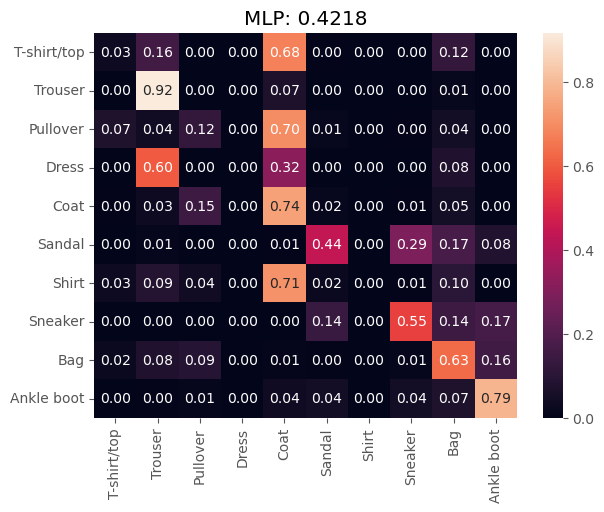

In [17]:
labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
compare_mlp_cnn(None,mlp,X_test,y_test,labels)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 24)        240       
                                                                 
 activation_12 (Activation)  (None, 28, 28, 24)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 24)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 24)        5208      
                                                                 
 activation_13 (Activation)  (None, 14, 14, 24)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 24)          0         
 g2D)                                                 

2023-11-24 19:27:38.824163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1871/1875 [============================>.] - ETA: 0s - loss: 0.0270 - accuracy: 0.8136

2023-11-24 19:28:04.322530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 28s 12ms/step - loss: 0.0270 - accuracy: 0.8136 - val_loss: 0.0285 - val_accuracy: 0.8249
Epoch 2/15
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0291 - accuracy: 0.8396 - val_loss: 0.0294 - val_accuracy: 0.8475
Epoch 3/15
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0343 - accuracy: 0.8242 - val_loss: 0.0392 - val_accuracy: 0.8012
Epoch 4/15
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0363 - accuracy: 0.8166 - val_loss: 0.0347 - val_accuracy: 0.8243
Epoch 5/15
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0381 - accuracy: 0.8084 - val_loss: 0.0363 - val_accuracy: 0.8174
Epoch 6/15
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0376 - accuracy: 0.8111 - val_loss: 0.0415 - val_accuracy: 0.7918
Epoch 7/15
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0378 - accuracy: 0.8101 - val_loss: 0.0331 - val_accura

2023-11-24 19:32:49.966337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
CPU times: user 4min 44s, sys: 1min 16s, total: 6min 1s
Wall time: 5min 13s


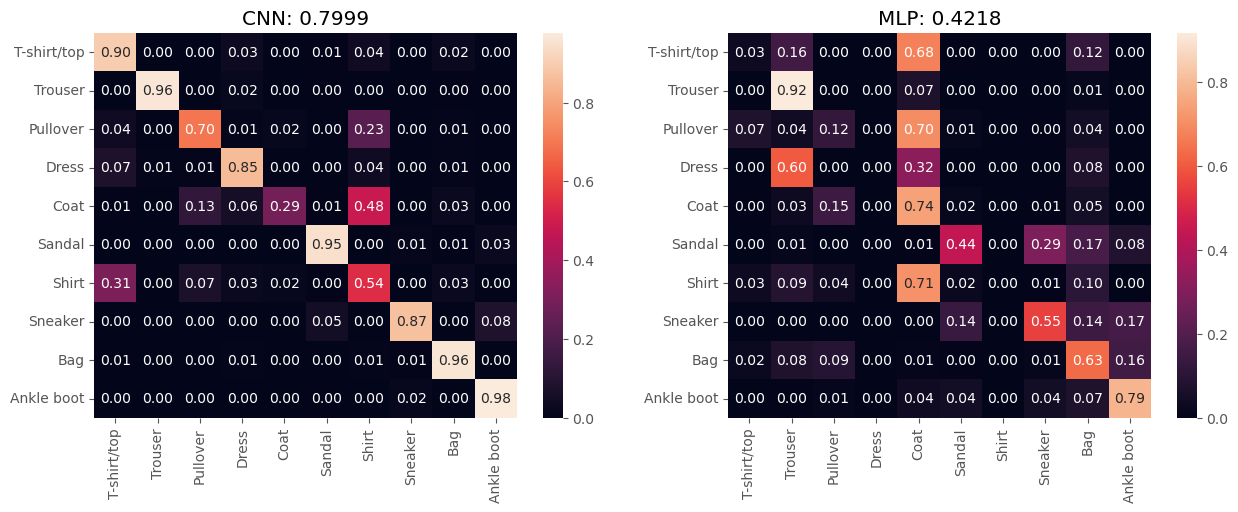

In [18]:
%%time

# changes: 
#    1. Baseline: 2 conv layers and two output layers
cnn1 = Sequential()

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same') )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), 
                           ) )
    

# add one layer on flattened output
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

input_shape = [None, 28,28,1]
cnn1.build(input_shape)
print(cnn1.summary())

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn1.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1,
        validation_data=(X_test,y_test_ohe))

compare_mlp_cnn(cnn1,mlp,X_test,y_test,labels)

In [ ]:
%%time
# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

cnn2 = Sequential()

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',
                    ) ) # more compact syntax

    # max pooling
    cnn2.add( MaxPooling2D(pool_size=(2, 2) ) )
    

# add one layer on flattened output
cnn2.add( Dropout(0.25) ) # add some dropout for regularization after conv layers
cnn2.add( Flatten() )
cnn2.add( Dense(256, activation='relu') )
cnn2.add( Dropout(0.5) ) # add some dropout for regularization, again!
cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

input_shape = [None, 28,28,1]
cnn2.build(input_shape)
print(cnn2.summary())

history = cnn2.fit(X_train, y_train_ohe, 
            batch_size=128, epochs=30, 
            shuffle=True, verbose=1,
            validation_data=(X_test,y_test_ohe))



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten_7 (Flatten)         (None, 3136)             

2023-11-24 19:32:52.648056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.8038

2023-11-24 19:33:24.382104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 36s 67ms/step - loss: 0.5478 - accuracy: 0.8038 - val_loss: 0.3869 - val_accuracy: 0.8621
Epoch 2/30
469/469 [==============================] - 27s 59ms/step - loss: 0.3487 - accuracy: 0.8775 - val_loss: 0.3304 - val_accuracy: 0.8834
Epoch 3/30
469/469 [==============================] - 28s 59ms/step - loss: 0.3052 - accuracy: 0.8918 - val_loss: 0.3049 - val_accuracy: 0.8921
Epoch 4/30
469/469 [==============================] - 29s 61ms/step - loss: 0.2837 - accuracy: 0.8995 - val_loss: 0.2954 - val_accuracy: 0.8923
Epoch 5/30
469/469 [==============================] - 29s 61ms/step - loss: 0.2673 - accuracy: 0.9048 - val_loss: 0.2830 - val_accuracy: 0.9021
Epoch 6/30
469/469 [==============================] - 28s 59ms/step - loss: 0.2604 - accuracy: 0.9086 - val_loss: 0.2818 - val_accuracy: 0.9016
Epoch 7/30
181/469 [==========>...................] - ETA: 14s - loss: 0.2570 - accuracy: 0.9133

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
compare_mlp_cnn(cnn2,mlp,X_test,y_test,labels)

In [ ]:
cnn2.evaluate(X_test,y_test_ohe,verbose=0)

In [ ]:
# want to save this model for later?
cnn2.save('large_data/mnist_cnn.h5')

In [ ]:
from tensorflow.keras.models import load_model

cnn_mnist = load_model('large_data/mnist_cnn.h5')
compare_mlp_cnn(cnn_mnist,None,X_test,y_test,labels)